# Transfer learning

### 1. Train/Test Data download
- 이전 chapter에서 만든 module을 이용해 데이터를 다운로드 한다

### 2. Get pretrained model
- `torchvision.models.efficientnet_b0` 을 사용한다
- EfficientNet은 특정한 Compute budget에 맞춰 최대한의 효과를 얻기 위한 depth 및 kernel size 조정을 한 모델이다 (자세한건 Obsidian에 더 정리해 둠)

### 3. Create transform for pretrained model + Create Dataloader
- 우리가 사용할 Pretrained model에 맞춘 Transform을 준비한다
    1) 우리가 직접 만드는 방법
        - 장점: 내가 일일히 조작할 수 있음
        - 단점: 내가 일일히 만들어야 함
    2) 모델로 부터 가져오는 방법
        - 장점: 자동으로 만들어 짐
        - 단점: 편집할 수 있는 범위가 제한됨
- 모델에서 가져온 Transform을 이용해 Dataloader를 만들어 본다
    - 모델에서 사용한쪽이 interpolation을 포함해 이런저런걸 많이 함

### 4. Freeze base model feature layer
- `torchvision.models.efficientnet_b0`은 크게 features, avgpool, classifier의 3단계 레이어로 구분될 수 있다
- 우리는 여기에서 feature는 있는 그대로 쓰고 classifier만 바꿔서 training하고자 한다
- 따라서 feature layer를 freeze하고 그로 인한 변화를 torchinfo.summary를 통해 비교해 본다

### 5. Train model
- Going modular에서 미리 만들어 둔 엔진을 이용해 training 해본다
- Training을 해보니 다음을 알 수 있었음
    - 할때 마다 결과가 생각보다 들쭉 날쭉임
    - 안될 때는 좀 터무니 없이 안좋게 결과가 나오기도 함
    - Data가 작을때는 특히나 ML이 운이 많이 따르는것 아닌가 싶다

### 6. Evaluate model
- 예전에 만들어 둔 plot_loss_curve와 display_confusion_matrix를 돌려본다
- 잘 나올때는 꽤 그럭저럭 잘 나온다

In [1]:
# 1. Train/Test Data download

import pathlib

from going_modular import *

train_dir, test_dir = download_pss_data(pathlib.Path('data'))

print()
print(f'train_dir: {train_dir}')
print(f'test_dir: {test_dir}')

data/pizza_steak_sushi directory exists.
Unzipping pizza, steak, sushi data...
Removed pizza, steak, sushi zip file.
Pizza, steak, sushi data downloaded and unzipped successfully.

train_dir: data/pizza_steak_sushi/train
test_dir: data/pizza_steak_sushi/test


In [2]:
# 2. Get pretrained model
import torch
import torchinfo
import torchvision

device = "cuda" if torch.cuda.is_available() else "cpu"

weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # .DEFAULT = best available weights 
model = torchvision.models.efficientnet_b0(weights=weights).to(device)

# print summary of model with torchinfo.summary
#
# model.features : feature extractor CNN layer
# model.avgbpool : average pooling layer
# model.classifier : fully connected layer  
#
torchinfo.summary(
    model = model, 
    input_size=(32,3,224,224), 
    col_names=['input_size','output_size','num_params','trainable'],
    col_width=20,
    row_settings=['var_names']
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112

In [3]:
# 3. Create transform for pretrained model

import torchvision
from going_modular import *

# 3-1. Manual creation
#
# 여기서 mean과 std는 EfficientNet을 train한 데이터인 ImageNet 데이터셋의 평균과 표준편차를 사용한다.
#

manual_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224,224)), # 1. Reshape all images to 224x224 (though some models may require different sizes)
    torchvision.transforms.ToTensor(), # 2. Turn image values to between 0 & 1 
    torchvision.transforms.Normalize(
        mean=[0.485,0.456,0.406], # 3. A mean of [0.485, 0.456, 0.406] (across each colour channel)
        std=[0.229,0.224,0.225] # 4. A standard deviation of [0.229, 0.224, 0.225] (across each colour channel),
    )
])
print('manual_transform:')
print(manual_transform)
print()

# 3-2. Using pretrained model's transform
#
# 여기서 DEFAULT란 pretrained model의 best available weights를 의미한다
#
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # .DEFAULT = best available weights
auto_transforms = weights.transforms()

print('auto_transforms:')
print(auto_transforms)
print()

# 3-3. Create dataloader
train_dataloader, test_dataloader, classes = create_dataloaders(
                                                train_dir = train_dir, 
                                                test_dir = test_dir, 
                                                transform = auto_transforms,
                                                batch_size=32)

print(f'len(train_dataloader): {len(train_dataloader)}')
print(f'len(test_dataloader): {len(test_dataloader)}')
print(f'classes: {classes}({len(classes)})')

manual_transform:
Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)

auto_transforms:
ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

len(train_dataloader): 8
len(test_dataloader): 3
classes: ['pizza', 'steak', 'sushi'](3)


In [4]:
# 4. Freeze base model feature layer
import torch
import torchinfo

# features layer를 'freeze'함으로써 training loop에서 이 부분이 training되지 않도록 한다
# 이는 requires_grad를 False로 설정함으로써 이루어진다

for param in model.features.parameters():
    param.requires_grad = False

# Classifier를 원래 모델의 1000개 class에서 현재에 맞게 변경한다
output_shape = len(classes)
model.classifier = torch.nn.Sequential(
    # inplace=True : dropout의 zeroing을 input에 직접 in-place로 수행한다. 
    #                더 memory efficient하다
    #                하지만 input자체를 바꿔버리므로 이 input을 다른 연산에서도
    #                사용하려면 False로 설정해야 한다
    torch.nn.Dropout(p=0.2, inplace=True), 
    torch.nn.Linear(in_features=1280,
                    out_features=output_shape,
                    bias=True)  # bias를 learning할 것인지 여부
).to(device)

#
# 마지막이 줄어서 3492.77MB -> 3487.41MB로 줄어든것을 확인 할 수 있다
#
torchinfo.summary(
    model, 
    input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
    verbose=0,
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=20,
    row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

In [8]:
# 5. Train model
#
# 근데 이거 몇번 해보니까 안나올때는 좀 터무니 없이 안나오기도 하는 것 같다
# 머신 러닝이라는게 약간 운도 필요한 것인 듯...
#
import timeit
import torch

t_beg = timeit.default_timer()

loss_func = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

results = train(
    model=model,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    loss_fn=loss_func,
    optimizer=optimizer,
    num_epochs=20,
    device=device
)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.8961 | train_acc: 0.6445 | test_loss: 0.9119 | test_acc: 0.7718
Epoch: 2 | train_loss: 0.9075 | train_acc: 0.6914 | test_loss: 0.8951 | test_acc: 0.7509
Epoch: 3 | train_loss: 0.8894 | train_acc: 0.7031 | test_loss: 0.8852 | test_acc: 0.7519
Epoch: 4 | train_loss: 0.8650 | train_acc: 0.7969 | test_loss: 0.8682 | test_acc: 0.7936
Epoch: 5 | train_loss: 0.8663 | train_acc: 0.7070 | test_loss: 0.8477 | test_acc: 0.8144
Epoch: 6 | train_loss: 0.8455 | train_acc: 0.8086 | test_loss: 0.8387 | test_acc: 0.8343
Epoch: 7 | train_loss: 0.8414 | train_acc: 0.6797 | test_loss: 0.8282 | test_acc: 0.8343
Epoch: 8 | train_loss: 0.7964 | train_acc: 0.8555 | test_loss: 0.8261 | test_acc: 0.8343
Epoch: 9 | train_loss: 0.8433 | train_acc: 0.6836 | test_loss: 0.8002 | test_acc: 0.8030
Epoch: 10 | train_loss: 0.7933 | train_acc: 0.6992 | test_loss: 0.7888 | test_acc: 0.8134
Epoch: 11 | train_loss: 0.8203 | train_acc: 0.7422 | test_loss: 0.7845 | test_acc: 0.8030
Epoch: 12 | train_l

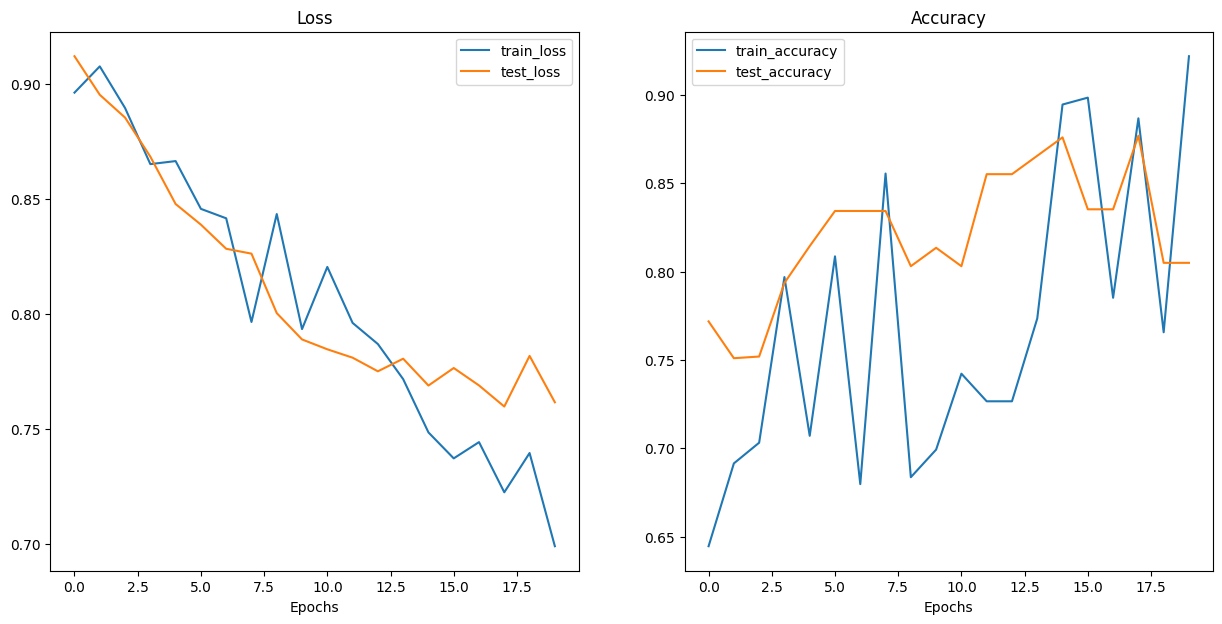

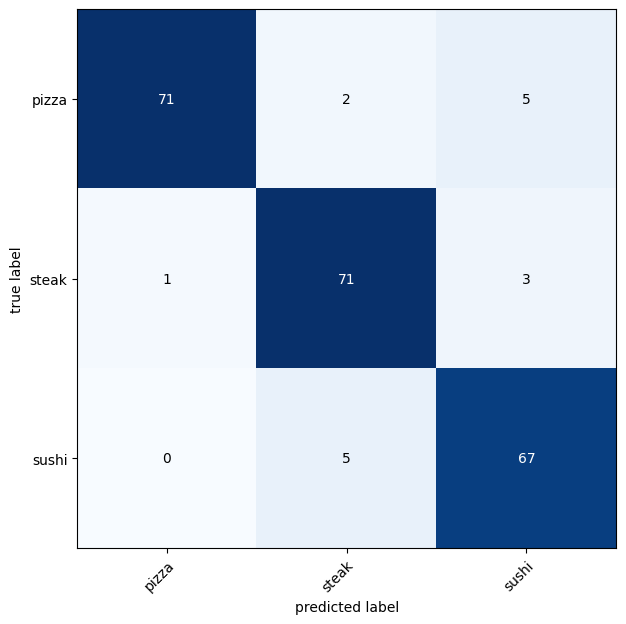

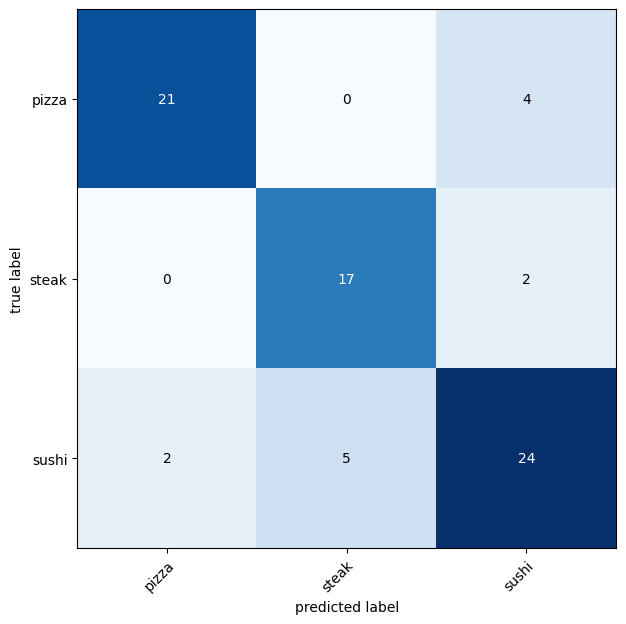

In [9]:
# 6. Evaluate results

plot_loss_curves(results)
display_confusion_matrix(train_dataloader, model, classes, device)
display_confusion_matrix(test_dataloader, model, classes, device)